# LFPs decoding 
## MIT - Brain and cognitive sciences April 2, 2019 - Computational tutorial

### Code source: Omar Costilla-Reyes
### License: BSD 3 clause

In [141]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import sklearn.ensemble
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.model_selection import cross_validate
import matplotlib.ticker as ticker

In [142]:
#defining a scoring function for our machine learning models

In [143]:
scoring = {'f_score motion': make_scorer(f1_score, average = None, labels = [0]),
       'f_score color': make_scorer(f1_score, average = None, labels = [1])}

In [144]:
#specify the session of the experiment
session = '110120'

In [100]:
#this is the color data
X_color = np.load('X_color_PFC_V4_lfp_' + session + '.npy')
#area labels for the electrodes (match with data)
y_color_elect = np.load('y_color_PFC_V4_lfp_' + session + '.npy')

In [101]:
print('X_color.shape')
print(X_color.shape)
print('#electrodes, #trials, #features (time)')
#preprocessing: downsampled from 2500 to 800

X_color.shape
(47, 372, 800)
#electrodes, #trials, #features (time)


In [102]:
print('Color data has nan?')
print(np.isnan(X_color).any())

Color data has nan?
False


In [103]:
print('y_color_elect.shape')
print(y_color_elect.shape)
print(np.unique(y_color_elect, return_counts=True))

y_color_elect.shape
(47,)
(array(['PFC', 'V4'], dtype='<U3'), array([36, 11], dtype=int64))


In [104]:
#this is the motion data
X_motion = np.load('X_motion_PFC_V4_lfp_' + session + '.npy')
#area labels for the electrodes (match with data)
y_motion_elect = np.load('y_motion_PFC_V4_lfp_' + session + '.npy')

In [105]:
print('X_motion.shape')
print(X_motion.shape)
print('#electrodes, #trials, #features (time)')

X_motion.shape
(47, 370, 800)
#electrodes, #trials, #features (time)


In [106]:
print('Motion data has nan?')
print(np.isnan(X_motion).any())

Motion data has nan?
False


In [107]:
print('y_motion_elect.shape')
print(y_motion_elect.shape)
print(np.unique(y_motion_elect, return_counts=True))

y_motion_elect.shape
(47,)
(array(['PFC', 'V4'], dtype='<U3'), array([36, 11], dtype=int64))


color rule
X_rule_PFC.shape
(36, 372, 800)
X_rule_V4.shape
(11, 372, 800)


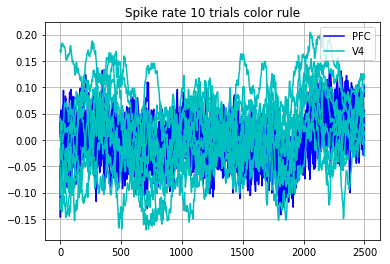

motion rule
X_rule_PFC.shape
(36, 370, 800)
X_rule_V4.shape
(11, 370, 800)


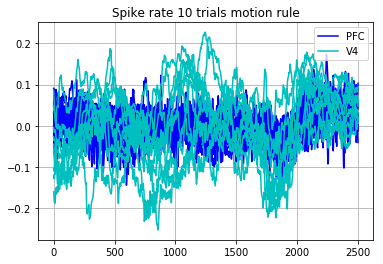

In [108]:
def plot_raw(X_rule, y_rule_elect, electrode, num_trials, rule, time):
    X_rule_PFC = X_rule[y_rule_elect == 'PFC']
    X_rule_V4 = X_rule[y_rule_elect == 'V4']

    print(rule  + ' rule')
    print('X_rule_PFC.shape')
    print(X_rule_PFC.shape)
    print('X_rule_V4.shape')
    print(X_rule_V4.shape)

    #plotting some of the data to see what is going on inside the 
    #plt.plot(X_rule_PFC[0], c='darkorchid')

    for i, trial in enumerate(X_rule_PFC[electrode][:num_trials]):
        plt.plot(time, trial, c='blue', label='PFC' if i == 0 else "")

    for i, trial in enumerate(X_rule_V4[electrode][:num_trials]):
        plt.plot(time, trial, c='c', label='V4' if i == 0 else "")
        
    plt.grid(which='both')
    plt.legend(loc='upper right')
    plt.title('Raw LFP ' + str(num_trials) + ' trials ' + rule + ' rule')
    plt.show()

#defining the time vector
time = np.linspace(0, 2500, num=X_motion.shape[2])

electrode = 2
num_trials = 10
rule = 'color'
plot_raw(X_color, y_color_elect, electrode, num_trials, rule, time)

rule = 'motion'
plot_raw(X_motion, y_motion_elect, electrode, num_trials, rule, time)

In [109]:
all_areas = np.unique(y_color_elect) 
#can be motion (share the same number of areas, since they where adquired at the same session)
print(all_areas)

['PFC' 'V4']


In [110]:
area = 'PFC'

In [111]:
#defining the time window to train the model
time_window = 50
#crossvalidation
cv = 5
#folder
model_name = 'svm'
folder = 'lfp_analysis_motion_color_cv_' + str(cv) + '_'+ model_name +'_'+ str(time_window) + 'ms_' + session + '_' + area +'/'
if not os.path.exists(folder):
    os.makedirs(folder)

In [112]:
#clf = sklearn.ensemble.ExtraTreesClassifier(n_jobs=-1, n_estimators=50)
# print(clf)
clf = svm.LinearSVC()

In [113]:
#?clf

In [114]:
#using fancy indexing to extract electrode data (and its trails from an area)
print('All area motion shape (neurons x trials x time domain (features))')
print(X_motion.shape)
X_motion_area = X_motion[y_motion_elect == area]
print('Current area motion shape (neurons x trials x time domain (features))')
print(X_motion_area.shape)

All area motion shape (neurons x trials x time domain (features))
(47, 370, 800)
Current area motion shape (neurons x trials x time domain (features))
(36, 370, 800)


In [115]:
#rolling the trials axis first, since we are going to classify motion/color given the trials samples
X_motion_area = np.rollaxis(X_motion_area, 1, 0)
print(X_motion_area.shape)

(370, 36, 800)


In [116]:
#generating the labels for motion from the length of the trials (samples)
y_motion_area = np.repeat(0,int(X_motion_area.shape[0]))
print(np.unique(y_motion_area, return_counts=True))

(array([0]), array([370], dtype=int64))


In [117]:
#color processing

In [118]:
#using fancy indexing to extract electrode data (and its trails from an area)
X_color_area = X_color[y_color_elect == area]
print(X_color_area.shape)

(36, 372, 800)


In [119]:
#rolling the trials axis first
X_color_area = np.rollaxis(X_color_area, 1, 0)
print(X_color_area.shape)

(372, 36, 800)


In [120]:
#generating the labels for color from the length of the trials (samples)
y_color_area = np.repeat(1,int(X_color_area.shape[0]))
print(np.unique(y_color_area, return_counts=True))

(array([1]), array([372], dtype=int64))


In [121]:
'motion and color area shapes'
print(X_motion_area.shape)
print(X_color_area.shape)

(370, 36, 800)
(372, 36, 800)


In [122]:
#concatenating motion and color by the trials
X_motion_color_area = np.concatenate((X_motion_area, X_color_area), axis=0)
print('X_motion_color_area.shape \n(trials x neurons x time domain)')
print(X_motion_color_area.shape)

X_motion_color_area.shape 
(trials x neurons x time domain)
(742, 36, 800)


In [123]:
y_motion_color_area = np.concatenate((y_motion_area, y_color_area))
print(np.unique(y_motion_color_area, return_counts=True))

(array([0, 1]), array([370, 372], dtype=int64))


In [124]:
#split our data array into windows arrays

In [125]:
split_area_windows = np.array_split(X_motion_color_area, X_motion_color_area.shape[2]/time_window, axis=2)

In [126]:
#what has been created?
print('split_area_windows info')
print(type(split_area_windows))
print('length ' + str(len(split_area_windows)))
#iterate over the first five element
for i, window in enumerate(split_area_windows):
    print('element #' + str(i) )
    print(window.shape)

split_area_windows info
<class 'list'>
length 16
element #0
(742, 36, 50)
element #1
(742, 36, 50)
element #2
(742, 36, 50)
element #3
(742, 36, 50)
element #4
(742, 36, 50)
element #5
(742, 36, 50)
element #6
(742, 36, 50)
element #7
(742, 36, 50)
element #8
(742, 36, 50)
element #9
(742, 36, 50)
element #10
(742, 36, 50)
element #11
(742, 36, 50)
element #12
(742, 36, 50)
element #13
(742, 36, 50)
element #14
(742, 36, 50)
element #15
(742, 36, 50)


In [127]:
#defining the time vector
time = np.linspace(100, 2500, num=len(split_area_windows))
print(time)

[ 100.  260.  420.  580.  740.  900. 1060. 1220. 1380. 1540. 1700. 1860.
 2020. 2180. 2340. 2500.]


In [128]:
#modelling
#we have the data ready now for processing in the machine learning algorithms!

#for the modelling results wee are interested in the f-score (f1-score) metric
#?f1_score

#we are going to obtian the mean and the standard deviation of the folds f-scores in our modelling part

In [129]:
def cross_validate_clf(split_area_windows, y_motion_color_area, cv, scoring, clf, folder, area):
    color_f_score = []
    motion_f_score = []

    color_f_score_std = []
    motion_f_score_std = []

    j = 0
    for X_window in split_area_windows:
        j = j+1
        print('Window iteration #' + str(j))
        print('window shape of current iteration')
        print(X_window.shape)
        #reshaping the array for samples = trials features = electrodes by time features
        X_window  = np.reshape((X_window), (X_window.shape[0], X_window.shape[1]* X_window.shape[2]))
        #scikit learn function to crossvalidate
        out = cross_validate(clf, X_window, y_motion_color_area, scoring=scoring, cv=cv, return_train_score=False, n_jobs=-1)
        i = 0
        num_elements_cv = len(out)
        #iterating over the dictionary
        for key, value in out.items():
            i = i + 1
            print('crossvalidation  value #' + str(i))
            print(key)
            print(value)
            if i == num_elements_cv-1:
                #calculating the mean of the crossvalidation results
                motion_f_score.append(np.average(value))
                #calculating the standard deviation of the crossvalidated results
                motion_f_score_std.append(np.std(value))
    #             print('motion_f_score')
    #             print(motion_f_score)
            if i == num_elements_cv:
                color_f_score.append(np.average(value))
                color_f_score_std.append(np.std(value))
    #             print('color_f_score')
    #             print(color_f_score)

    #transforming lists to numpy arrays
    motion_f_score = np.array([motion_f_score])
    motion_f_score = motion_f_score[0]

    color_f_score = np.array([color_f_score])
    color_f_score = color_f_score[0]

    motion_f_score_std = np.array([motion_f_score_std])
    motion_f_score_std = motion_f_score_std[0]

    color_f_score_std = np.array([color_f_score_std])
    color_f_score_std = color_f_score_std[0]

    #saving the results of the current modelling for future use (and not need to re run again)
    np.savetxt(folder + area + '_motion_score_' + str(time_window) + 'ms_window.txt', motion_f_score, fmt='%10.5f')
    np.savetxt(folder + area + '_motion_score_std' + str(time_window) + 'ms_window.txt', motion_f_score_std, fmt='%10.5f')

    np.savetxt(folder + area + '_color_score_' + str(time_window) + 'ms_window.txt', color_f_score, fmt='%10.5f')
    np.savetxt(folder + area + '_color_score_std' + str(time_window) + 'ms_window.txt', color_f_score_std, fmt='%10.5f')

    return motion_f_score, color_f_score, motion_f_score_std, color_f_score_std


In [130]:
motion_f_score, color_f_score, motion_f_score_std, color_f_score_std = cross_validate_clf(split_area_windows,
                                                                                          y_motion_color_area, cv,
                                                                                          scoring, clf, folder, area)

Window iteration #1
window shape of current iteration
(742, 36, 50)
crossvalidation  value #1
fit_time
[0.1376245  0.13563704 0.13663483 0.14062309 0.13463974]
crossvalidation  value #2
score_time
[0.20945573 0.21045303 0.20945573 0.21543932 0.20945573]
crossvalidation  value #3
test_f_score motion
[0.48447205 0.45033113 0.51948052 0.56603774 0.54193548]
crossvalidation  value #4
test_f_score color
[0.39416058 0.43537415 0.47887324 0.49635036 0.4964539 ]
Window iteration #2
window shape of current iteration
(742, 36, 50)
crossvalidation  value #1
fit_time
[0.13563704 0.13663459 0.13663387 0.15259194 0.13663435]
crossvalidation  value #2
score_time
[0.20997047 0.20997024 0.20997071 0.21196508 0.21096778]
crossvalidation  value #3
test_f_score motion
[0.57861635 0.47741935 0.58333333 0.5        0.52229299]
crossvalidation  value #4
test_f_score color
[0.51798561 0.43356643 0.453125   0.44285714 0.46043165]
Window iteration #3
window shape of current iteration
(742, 36, 50)
crossvalidatio

In [131]:
#sample of the results
print('motion_f_score')
print(motion_f_score)

print('\nList lenght (motion_f_score) ' + str(len(motion_f_score)))

motion_f_score
[0.51245138 0.53233241 0.5389364  0.5239161  0.706563   0.80210097
 0.76568933 0.65498977 0.69372691 0.71309293 0.64955894 0.81450955
 0.74722937 0.6641261  0.67512669 0.60354369]

List lenght (motion_f_score) 16


In [132]:
#plot for mean and using function fill (in between) in matplotlib for standard deviation

def plot_decoding_results(motion_f_score, color_f_score, motion_f_score_std, color_f_score_std, folder, area):
    plt.plot(time, motion_f_score, label='Motion', marker='.', color='green')
    plt.fill_between(time, motion_f_score - motion_f_score_std, motion_f_score + motion_f_score_std, alpha=0.5, color='green')
    plt.plot(time, color_f_score, label='Color', marker='.', color='magenta')
    plt.fill_between(time, color_f_score - color_f_score_std, color_f_score + color_f_score_std, alpha=0.5, color='magenta')


    # horizontal line to exemplify our chance level
    y_for_chance = np.repeat(0.50, len(split_area_windows))

    plt.plot(time, y_for_chance, '--', c='black')
    plt.ylim([0.4, 1])
    plt.grid(which='both')
    plt.minorticks_on()
    plt.xlabel('Time (ms)')
    plt.legend(loc='upper right')
    plt.ylabel('decoder f-score')

    # show y axis as percentage
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
    plt.axvline(x=500, c='black')

    # vertical lines for cue and stimulus
    plt.text(500.1, 0.5, 'Cue', rotation=90)
    plt.text(1500.1, 0.5, 'Stimulus', rotation=90)

    plt.axvline(x=1500, c='black')
    plt.title('Motion and color decoding of area ' + area + '- Raw LFP')
    fig = plt.gcf()
    fig.set_size_inches(10, 5)
    fig.savefig(folder + area + '_motion_color_plot.png', format='png')


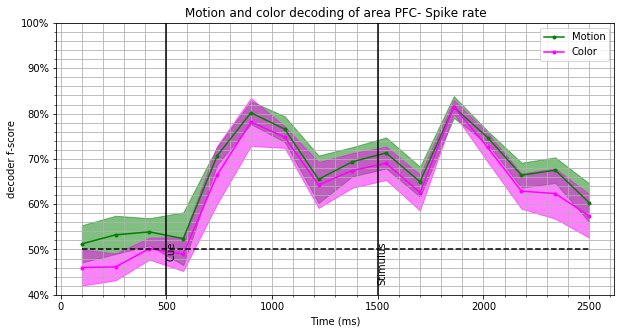

In [133]:
plot_decoding_results(motion_f_score, color_f_score, motion_f_score_std, color_f_score_std, folder, area)

In [134]:
#modelling for V4
areas = np.unique(y_motion_elect)
print(areas)

['PFC' 'V4']


In [135]:
area = 'V4'

In [136]:
time_window = 50
cv = 5
#folder
model_name = 'svm'
folder = 'lfp_analysis_motion_color_cv_' + str(cv) + '_'+ model_name +'_'+ str(time_window) + 'ms_' + session + '_' + area +'/'
if not os.path.exists(folder):
    os.makedirs(folder)

In [137]:
#clf = sklearn.ensemble.ExtraTreesClassifier(n_jobs=-1, n_estimators=50)
clf = svm.LinearSVC()
print(clf)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [138]:
#we also can do all areas at once with:
#all_areas = np.unique(y_color_elect)
#for area in all_areas:

X_motion_area = X_motion[y_motion_elect == area]
print(X_motion_area.shape)
X_motion_area = np.rollaxis(X_motion_area, 1, 0)
print(X_motion_area.shape)
#generating the labels for motion
y_motion_area = np.repeat(0,int(X_motion_area.shape[0]))
print(np.unique(y_motion_area, return_counts=True))

X_color_area = X_color[y_color_elect == area]
print(X_color_area.shape)
X_color_area = np.rollaxis(X_color_area, 1, 0)
print(X_color_area.shape)
#generating the labels for color
y_color_area = np.repeat(1,int(X_color_area.shape[0]))
print(np.unique(y_color_area, return_counts=True))

#concatenating motion and color by the trials
X_motion_color_area = np.concatenate((X_motion_area, X_color_area), axis=0)
print(X_motion_color_area.shape)
y_motion_color_area = np.concatenate((y_motion_area, y_color_area))
print(np.unique(y_motion_color_area, return_counts=True))


split_area_windows = np.array_split(X_motion_color_area, X_motion_color_area.shape[2]/time_window, axis=2)


#what has been created?
print(type(split_area_windows))
print(len(split_area_windows))

time = np.linspace(100, 2500, num=len(split_area_windows))

(11, 370, 800)
(370, 11, 800)
(array([0]), array([370], dtype=int64))
(11, 372, 800)
(372, 11, 800)
(array([1]), array([372], dtype=int64))
(742, 11, 800)
(array([0, 1]), array([370, 372], dtype=int64))
<class 'list'>
16


In [139]:
motion_f_score, color_f_score, motion_f_score_std, color_f_score_std = cross_validate_clf(split_area_windows,
                                                                                          y_motion_color_area, cv,
                                                                                          scoring, clf, folder, area)

Window iteration #1
window shape of current iteration
(742, 11, 50)
crossvalidation  value #1
fit_time
[0.12219214 0.12219143 0.12219143 0.12219191 0.15909243]
crossvalidation  value #2
score_time
[0.20946622 0.20946574 0.20846868 0.2094655  0.20947409]
crossvalidation  value #3
test_f_score motion
[0.44025157 0.52830189 0.55033557 0.53793103 0.55128205]
crossvalidation  value #4
test_f_score color
[0.35971223 0.46043165 0.54421769 0.55629139 0.5       ]
Window iteration #2
window shape of current iteration
(742, 11, 50)
crossvalidation  value #1
fit_time
[0.1216743  0.12167501 0.12167454 0.12167382 0.12167454]
crossvalidation  value #2
score_time
[0.20945978 0.2094593  0.20946002 0.20946026 0.20946002]
crossvalidation  value #3
test_f_score motion
[0.39705882 0.50955414 0.47222222 0.50314465 0.4516129 ]
crossvalidation  value #4
test_f_score color
[0.49382716 0.45390071 0.5        0.42335766 0.39716312]
Window iteration #3
window shape of current iteration
(742, 11, 50)
crossvalidatio

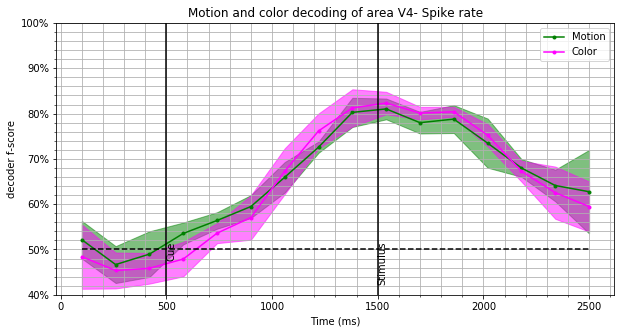

In [140]:
plot_decoding_results(motion_f_score, color_f_score, motion_f_score_std, color_f_score_std, folder, area)